Here we show how to use our models.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

# Add the relative path to the system path
sys.path.append(os.path.abspath("../train"))

from PIL import Image, ImageDraw, ImageFont, ImageSequence

import torch as th
import torch.nn as nn
from torchvision import transforms

from ConvLSTM_model import ConvLSTM_Model
from utils import MnistSequenceDataset

from IPython.display import Image as IPython_Image

In [12]:
# Define function to add a border and title to a PIL image
def add_border_and_title(image, title, border_size=10, font_size=20, color="white"):
    # Add border
    width, height = image.size
    new_width = width + 2 * border_size
    new_height = height + 2 * border_size + font_size + 5  # Additional space for the title
    bordered_image = Image.new("RGB", (new_width, new_height), color=color)
    bordered_image.paste(image, (border_size, border_size + font_size + 5))
    # Add title text
    draw = ImageDraw.Draw(bordered_image)
    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except IOError:
        font = ImageFont.load_default()
    draw.text(((new_width-font_size)//4,border_size), title, fill="black", font=font)
    return bordered_image

# function to generate gif
def generate_gif(index, dataset, model, filename, predict):

    input_frames = dataset[index][0]
    output_frames = dataset[index][1]

    input_pil_frames = [transforms.ToPILImage()(frame) for frame in input_frames]
    true_pil_frames = [transforms.ToPILImage()(frame) for frame in output_frames]

    true_gif_list = input_pil_frames + true_pil_frames
    #true_gif_list[0].save(filename, save_all=True, append_images=true_gif_list[1:], duration=10, loop=0)

    input_pil_frames = [
        add_border_and_title(transforms.ToPILImage()(frame), "Input Frame")
        for frame in input_frames
    ]
    true_pil_frames = [
        add_border_and_title(transforms.ToPILImage()(frame), "Target Frame")
        for frame in output_frames
    ]

    if not predict:
        # List of frames as PIL Image objects
        # Duration sets the display time for each frame in milliseconds
        # Loop sets the number of loops. Default is 0 and means infinite
        true_gif_list = input_pil_frames + true_pil_frames
        true_gif_list[0].save(
            filename, save_all=True, append_images=true_gif_list[1:], duration=1000, loop=0
        )
    else:
        input_frames = input_frames.unsqueeze(0)
        mask_true = th.ones_like(input_frames)
        predicted_frames = model(input_frames, mask_true, schedule_sampling=False)
        input_frames = input_frames.squeeze(0)
        predicted_frames = predicted_frames.squeeze(0)
        print(predicted_frames.shape)
        predicted_pil_frames = [transforms.ToPILImage()(frame) for frame in predicted_frames]

        pred_gif_list = input_pil_frames + predicted_pil_frames

        predicted_pil_frames = [
            add_border_and_title(transforms.ToPILImage()(frame), "Predicted Frame", color="red")
            for frame in predicted_frames
        ]

        pred_gif_list = input_pil_frames + predicted_pil_frames
        pred_gif_list[0].save(
            filename, save_all=True, append_images=pred_gif_list[1:], duration=1000, loop=0
        )

# function to concatenate gifs
def concatenate_gifs_horizontally(gif1_path, gif2_path, output_path):
    # Open the two GIFs
    gif1 = Image.open(gif1_path)
    gif2 = Image.open(gif2_path)
    
    # Ensure the two GIFs have the same frame count
    frames1 = [frame.copy() for frame in ImageSequence.Iterator(gif1)]
    frames2 = [frame.copy() for frame in ImageSequence.Iterator(gif2)]
    max_frames = max(len(frames1), len(frames2))
    
    # Repeat frames if necessary to match lengths
    frames1 *= (max_frames // len(frames1)) + 1
    frames2 *= (max_frames // len(frames2)) + 1
    
    # Resize to ensure consistent heights
    common_height = max(gif1.height, gif2.height)
    frames1 = [frame.resize((frame.width, common_height)) for frame in frames1[:max_frames]]
    frames2 = [frame.resize((frame.width, common_height)) for frame in frames2[:max_frames]]
    
    # Concatenate frames horizontally
    concatenated_frames = []
    for frame1, frame2 in zip(frames1, frames2):
        new_width = frame1.width + frame2.width
        new_frame = Image.new("RGBA", (new_width, common_height))
        new_frame.paste(frame1, (0, 0))
        new_frame.paste(frame2, (frame1.width, 0))
        concatenated_frames.append(new_frame)
    
    # Save the concatenated GIF
    concatenated_frames[0].save(
        output_path,
        save_all=True,
        append_images=concatenated_frames[1:],
        loop=0,
        duration=gif1.info.get("duration", 100)
    )

In [35]:
seq_len = 9
data = np.load("../data/mnist/mnist_test_seq.npy").astype(np.float32)/255
train_idx = int(data.shape[1] * 0.9)
train_dataset = MnistSequenceDataset(data[:,:train_idx], seq_len, seq_len)
test_dataset = MnistSequenceDataset(data[:,train_idx:], seq_len, seq_len)

In [36]:
batch_size = 1
num_hidden = [64,32,32,16]
num_layers = len(num_hidden)
custom_model_config = {
    'in_shape': [1, 64, 64], # C, H, W
    'stride': 2, 
    'filter_size': [5,5,5,5], 
    'leaky_slope' : None,
    'max_pool' : True,
    'layer_norm' : True,
    'bias' : False,
    'transpose' : True,
    'patch_size': 1,
    'use_lstm_output': False
}

if th.cuda.is_available():
    print("CUDA is available!")
else:
    print("CUDA is not available.")

device = th.device("cuda" if th.cuda.is_available() else "cpu")

# Instantiate the model
input_dim = 3  # Assuming x_train shape is (batch_size, sequence_length, channels, height, width)
model = ConvLSTM_Model(num_layers, num_hidden, custom_model_config)

CUDA is not available.


In [37]:
# Load the model
folder_id = 1014459

model_name = f"/Users/marcozamp/Desktop/Deep-Learning-Project/mnist-models/{folder_id}/model_{folder_id}.pth"
state_dict = th.load(model_name, map_location=th.device('cpu'), weights_only=True)
# Remove `module.` prefix if it exists
new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}

# Load the adjusted state dict into the model
model.load_state_dict(new_state_dict, strict=True)

<All keys matched successfully>

## Check the model on the train set

In [38]:
!cd /Users/marcozamp/Desktop/Deep-Learning-Project/mnist-models/1014459
generate_gif(0, train_dataset, model, "./mnist_train_pred.gif", predict=True)
generate_gif(0, train_dataset, model, "./mnist_train_true.gif", predict=False)
concatenate_gifs_horizontally("./mnist_train_true.gif", "./mnist_train_pred.gif", f"./mnist_train_model_{folder_id}.gif")
!rm ./mnist_train_true.gif ./mnist_train_pred.gif

torch.Size([9, 1, 64, 64])


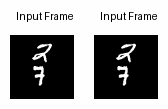

In [39]:
IPython_Image(filename=f"./mnist_train_model_{folder_id}.gif")

## Check the model on the test images

In [40]:
generate_gif(0, test_dataset, model, "./mnist_test_pred.gif", predict=True)
generate_gif(0, test_dataset, model, "./mnist_test_true.gif", predict=False)
concatenate_gifs_horizontally("./mnist_test_true.gif", "./mnist_test_pred.gif", f"./mnist_test_model_{folder_id}.gif")
!rm ./mnist_test_true.gif ./mnist_test_pred.gif

torch.Size([9, 1, 64, 64])


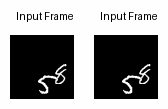

In [41]:
IPython_Image(filename=f"./mnist_test_model_{folder_id}.gif")